# 神経突起の成長モデル
神経細胞は他の細胞に比して特異な形態を持つ．またニューロンの種類およびその役割により基本的な細胞体，樹状突起，軸索等の構造は共通するものの，各部分の形態は異なる．このような形態はどのようにして発達するのだろうか．本節では**神経突起(neurite)** の**成長モデル(growth model)** を取り扱う．神経突起とは神経細胞において細胞体から伸びる突起の総称である．

## 神経突起の木構造
神経突起の形態は**樹状**突起 (dendrites; ギリシャ語で木を意味する*déndron*に由来) に代表されるように（生物としての）木に類似している．さらに分節(segment)に離散化することでグラフ理論における**木**(tree; 連結で閉路を持たないグラフ)として捉えることができる．

シミュレーション用にデータ構造を作成しよう．なお，Juliaで木構造を扱うためのライブラリ`AbstractTrees.jl`は使用しない．`tree_info`はInt型vector（要素数3）のlistであり，接続している分節の番号，遠心性位数，分節の種類(1: 末端, 0:中間)を表す．`seg_vec`は Float型vector（要素数2）のlistであり，分節の2次元極座標ベクトル(半径，角度)を表す．3次元に拡張することも可能であるが，本書では簡単のために2次元とする．多次元配列ではなくvectorのlistにしているのは，成長に伴って要素を追加していく際に配列に結合`cat`するよりlist化して追加`push!`する方が高速なためである．

In [1]:
using PyPlot, ProgressMeter, Distributions, Random
using PyPlot: matplotlib

rc("axes.spines", top=false, right=false)

In [2]:
tree_info_eg = Vector{Int64}[[1, 0, 0], [1, 0, 0], [2, 1, 0], [2, 1, 0], [3, 2, 1], 
                             [3, 2, 1], [4, 2, 1], [4, 2, 1], [8, 2, 1], [9, 2, 1], [9, 2, 1]];
seg_vec_eg = Vector{Float64}[[0.0, 0.0], [1, π/2], [√2, 3π/4], [√2, π/4], [√2/2, 3π/4],
                             [√2/2, π/4], [√2/2, 3π/4], [√2/2, π/4], [√2/2, π/4], [√2/2, 3π/4], [√2/2, π/4]];

木構造を描画するための関数を作成する．以下の`segments_lines`は`tree_info`と`seg_vec`から節点位置`pos`と各分節の両端点`lines`を返す関数である．`lines`は主に`matplotlib.collections.LineCollection`で用いる (`plot`を用いるより高速である)．

In [3]:
function segments_lines(tree_info, seg_vec, init_pos=nothing)
    num_segments = size(tree_info)[1]
    
    pos = zeros(num_segments, 2);
    if init_pos != nothing
        pos[1, :] = init_pos
    end
    
    for j in 1:num_segments
        pos[j, :] = pos[tree_info[j][1], :] + seg_vec[j][1] * [cos(seg_vec[j][2]), sin(seg_vec[j][2])]
    end
    
    lines = []
    for j in 1:num_segments
        x1, y1 = pos[tree_info[j][1], :]
        x2, y2 = pos[j, :]
        push!(lines, [(x1, y1), (x2, y2)])
    end
    return lines, pos
end;

In [4]:
lines_eg, _ = segments_lines(tree_info_eg, seg_vec_eg);

木構造を描画してみよう．以下では各部位の説明を加えており，{cite:p}`Koene2009-hv`, {cite:p}`Cuntz2010-in`を参考に作成した．

In [5]:
rc("font", family="Meiryo") # 日本語用フォント

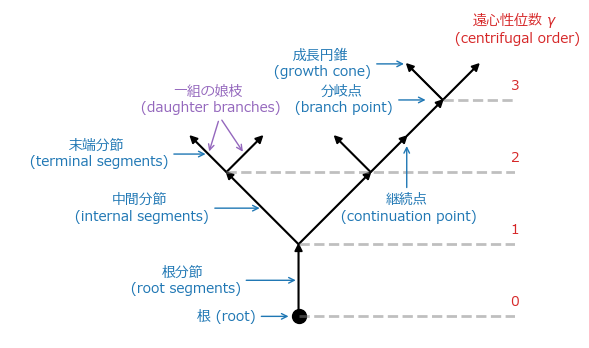

In [6]:
figure(figsize=(6, 6), dpi=100)
ax = PyPlot.axes()
for i in 1:length(tree_info_eg)
    x, y = lines_eg[i][1]
    dx, dy = lines_eg[i][2] .- lines_eg[i][1]
    arrow(x, y, dx, dy,width=0.01,head_width=0.1,head_length=0.1,length_includes_head=true,color="k")
end
scatter(0, 0, s=100, color="k") # root

text(3, 4, L"遠心性位数 $\gamma$"*"\n (centrifugal order)", size=10, color="tab:red", ha="center", va="center")
hlines_y = [0, 0, -1, 2];
for i in 1:4
    hlines(i-1, hlines_y[i], 3, color="gray", linestyle="dashed", linewidth=2, alpha=0.5)
    text(3, (i-1)+0.2, string(i-1), size=10, color="tab:red", ha="center", va="center")
end

arrowprops=Dict("arrowstyle" => "->", "color" => "tab:blue");
annotate("根 (root)", xy=(-0.1, 0), xytext=(-1.0, 0), size=10, color="tab:blue", ha="center", va="center", arrowprops=arrowprops)
annotate("根分節\n (root segments)", xy=(0, 0.5), xytext=(-1.6, 0.5), size=10, color="tab:blue", ha="center", va="center", arrowprops=arrowprops)
annotate("中間分節\n (internal segments)", xy=(-0.5, 1.5), xytext=(-2.2, 1.5), size=10, color="tab:blue", ha="center", va="center", arrowprops=arrowprops)
annotate("末端分節\n (terminal segments)", xy=(-1.25, 2.25), xytext=(-2.8, 2.25), size=10, color="tab:blue", ha="center", va="center", arrowprops=arrowprops)
annotate("分岐点\n (branch point)", xy=(1.8, 3), xytext=(0.6, 3), size=10, color="tab:blue", ha="center", va="center", arrowprops=arrowprops)
annotate("成長円錐\n (growth cone)", xy=(1.5, 3.5), xytext=(0.3, 3.5), size=10, color="tab:blue", ha="center", va="center", arrowprops=arrowprops)
annotate("継続点\n (continuation point)", xy=(1.5, 2.4), xytext=(1.5, 1.5), size=10, color="tab:blue", ha="center", va="center", arrowprops=arrowprops)
annotate("一組の娘枝\n (daughter branches)", xy=(-0.75, 2.25), xytext=(-1.25, 3), size=10, color="tab:purple", ha="center", va="center", arrowprops=Dict("arrowstyle" => "->", "color" => "tab:purple"))
annotate("", xy=(-1.25, 2.25), xytext=(-1.1, 2.74), ha="center", va="center", arrowprops=Dict("arrowstyle" => "->", "color" => "tab:purple"))

xlim(-4, 3); ylim(-0.3, 4); axis("off")
ax.set_aspect("equal")
tight_layout()

## Van Peltモデル
Van PeltモデルはVan Peltらによって構築された，神経突起の成長についての現象論的モデルである {cite:p}`Van_Pelt2002-vm`．以下では{cite:p}`Koene2009-hv`に基づいて記述する．なお，このモデルでは軸索誘導分子 (axon guidance molecules) 等の存在は無視している．

神経突起の成長の過程には分岐(branching)，伸長(elongation)，転向(turn)が含まれる．簡略化のため，空間を2次元にし，分節の太さおよび成長円錐が向きを変える時のsegment history tension model（後述）を省略する．またVan Peltモデルを元にした神経回路構築ソフトウェア**NETMORPH** {cite:p}`Koene2009-hv`ではシナプス結合の形成も含めたシミュレーションを行っている．

### 分岐 (branching)
時刻$[t_i, t_i + \Delta t]$において，$j$番目の末端分節(terminal segment)が分岐する確率は

$$
p_{i,j} = n_i^{-E}\cdot B_{\infty} e^{\frac{-t_i}{\tau}} \left(e^{\frac{\Delta t}{\tau}} - 1\right)\cdot \frac{2^{-S\gamma_j}}{C_{n_i}}
$$

で表される．ここで，$B_{\infty}, E, S, \tau$は定数である．$\gamma_j$は$j$番目の末端分節の遠心性位数(centrifugal order)であり，$n_i$は時刻$t_i$における末端分節の総計である．さらに

$$
{C_{n_i}} = \frac{1}{n_i}\sum\nolimits_{k = 1}^{n_i} {{2^{ - S{\gamma_k}}}}
$$

とする．$n_i^{-E}$は末端分節の総計に応じて分岐確率を変化させる項であり，$E$は競合変数(competition parameter)と呼ばれる．
$B_{\infty} e^{\frac{-t_i}{\tau}} \left(e^{\frac{\Delta t}{\tau}} - 1\right)$は経過時間に応じて分岐確率を変化させる項であり，$B_{\infty}$は$E=0$の場合の末端分節での分岐数の漸近的な期待値である．
$\frac{2^{-S\gamma_j}}{C_{n_i}}$の項は末端分節の遠心性位数に応じて分岐確率を変化させる項であり，$C_{n_i}$は正規化定数である．
$S=0$のときは末端分節は全て同じ確率で分岐するが，$S>0$のときは近位の末端分節，$S<0$のときは遠位の末端分節における分岐確率が大きくなる．

In [7]:
function branching_prob(t, dt, γ, n, C, B∞, E, S, τ)
    return (n^(-E))*B∞*exp(-t/τ)*(exp(dt/τ) - 1)*(2^(-S*γ))/C
end;

### 伸長 (elongation)
末端分節が伸長する速さ$\nu_e(t_i)\ [\mu m/s]$は正規分布 $\mathcal{N}(\mu_e, \sigma_e^2)$に従うとする {cite:p}`Van_Ooyen2014-fb`．伸長する長さは$\Delta L_j(t_i)=\nu_e(t_i) \cdot \Delta t$となる．

### 転向 (turn)
神経突起は真っ直ぐに伸び続けるわけではなく，向きを時折変えながら伸長する．伸長時に転向するかどうかの確率$p_d(t_i)$を次のようにする．

$$
p_d(t_i) = r_L\Delta L_j(t_i)
$$

ただし，$r_L\ [\mu m^{-1}]$は回転率を表す．確率$p_d(t_i)$により転向する部分は新しい分節として定義する．転向する角度は{cite:p}`Koene2009-hv`では転向角度の履歴を考慮したsegment history tension modelが導入されているが，本書では前述のように省略する．代わりに転向角度は一様分布$U(-\alpha, \alpha)\ \left(\alpha\in \left[0, \frac{\pi}{2}\right]\right)$に従うとする．

分岐した際にも娘枝の長さと角度の設定が必要となる．ここでは長さは末端分節の伸長と同じ正規分布に従うとする．また，分岐角度は2つの娘枝について一様分布$U(0, \beta_1),\ U(-\beta_2, 0)\ \left(\beta_1, \beta_2\in \left[0, \frac{\pi}{2}\right]\right)$にそれぞれ従うとする．

以上をまとめてシミュレーションを実装する．

In [8]:
function neurite_growth_model(tree_info_init, seg_vec_init, nt, dt, B∞, E, S, τ, μₑ, σₑ,
                              turn_rate=5, max_branch_angle=0.1π, max_turn_angle=5e-3π,
                              history_num=3)
    tree_info = copy(tree_info_init)
    seg_vec = copy(seg_vec_init)
    num_branching = 0
    
    if history_num > 1
        tree_info_history = []
        seg_vec_history = []
        history_timing = floor.(Int, collect(range(1, nt, length=history_num+1)))[2:end] 
    end
    
    @showprogress for tt in 1:nt
        t = tt*dt # Current time
        
        n, C = 0.0, 0.0
        for j in 1:size(tree_info)[1]
            if tree_info[j][3] == 1
                n += 1
                C += 2 ^(-S*tree_info[j][2])
            end
        end
        C /= n
        
        for j in 1:size(tree_info)[1]
            if tree_info[j][3] == 1
                γ = tree_info[j][2]
                p_branch = branching_prob(t, dt, γ, n, C, B∞, E, S, τ)
                if p_branch > rand()
                    # Neurite branching
                    num_branching += 1
                    branch_lens = (μₑ .+ randn(2) * σₑ)*dt　# branch length
                    branch_angles = [1, -1] .* rand(Uniform(0, max_branch_angle), 2)
                    for k in 1:2 # add two daughter branches
                        push!(tree_info, [j, γ+1, 1]) 
                        push!(seg_vec, [branch_lens[k], seg_vec[j][2]+branch_angles[k]])
                    end
                    tree_info[j][3] = 0 # reset centrifugal order of original branch
                else
                    # Neurite elongation
                    Δlen = (μₑ .+ randn() * σₑ)*dt
                    p_turn = turn_rate*Δlen
                    if p_turn > rand()
                        push!(tree_info, [j, γ, 1]) # add segment
                        seg_angle = seg_vec[j][2] + rand(Uniform(-max_turn_angle, max_turn_angle))
                        push!(seg_vec, [Δlen, seg_angle])
                        tree_info[j][3] = 0 # reset centrifugal order of original branch
                    else
                        seg_vec[j][1] += Δlen
                    end
                end
            end
        end
        if history_num > 1
            if tt in history_timing
                push!(tree_info_history, copy(tree_info))
                push!(seg_vec_history, copy(seg_vec))
            end
        end
    end
    println("Num. branching: ", num_branching)
    if history_num > 1
        return tree_info_history, seg_vec_history
    else
        return tree_info, seg_vec
    end
end;

パラメータを設定する．このパラメータは{cite:p}`Koene2009-hv`, {cite:p}`Van_Ooyen2014-fb`に基づいている．Van Peltモデルにおいて錐体細胞のような複雑な形態を作成するには，各部位に分割してシミュレーションし結合することが必要となる．今回は軸索のパラメータを用いる．

In [52]:
B∞ = 13.2; E = 0.319; S = -0.205; τ = 1681541; 
μₑ = 2.14e-4; σₑ = 3.98e-4;

turn_rate = 3
max_branch_angle = 0.25π
max_turn_angle = 1e-2π

T = 18*24*60*60 # duration of growth; convert 18 days to sec
dt = 200 # sec
nt = round(Int, T/dt);

シミュレーションを実行する．

In [53]:
history_num = 3 # 記録する状態の数; 等間隔で記録．
init_branch_num = 2 # 初めの神経突起枝の数

# 細胞体のパラメータ
tree_info_init = [[1, 0, 0]]
seg_vec_init = [[0.0, 0.0]]

# 初期神経突起のパラメータ （神経突起が放射状に出るように設定）
Random.seed!(0)
for i in 1:init_branch_num
    push!(tree_info_init, [1, 0, 1])
    push!(seg_vec_init, [(μₑ + randn()*σₑ)*dt, (i-1)/init_branch_num*2π+1e-2*randn()])
end

@time tree_info_history, seg_vec_history = neurite_growth_model(tree_info_init, seg_vec_init, nt, dt, B∞, E, S, τ, μₑ, σₑ,
                                                                turn_rate, max_branch_angle, max_turn_angle, history_num);

Num. branching: 40
  0.364073 seconds (49.79 k allocations: 5.013 MiB)


結果を表示する．初めの神経突起の数を2にしていてもそれ以上出ているように見えるのは最初期に分岐しているためである (細胞体を描画しなければ確認できる)．

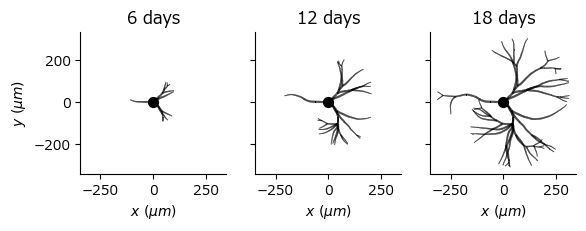

In [54]:
maxwidth, minwidth = 1.5, 0.5 # 描画する神経突起の最大/最小の太さ
days_range = floor.(Int, collect(range(1, 18, history_num+1)))[2:end]

fig, ax = subplots(1, history_num, sharex=true, sharey=true)
for i in 1:history_num
    lines, _ = segments_lines(tree_info_history[i], seg_vec_history[i]);
    linewidths = range(maxwidth, minwidth, length=length(lines));

    line_segments = matplotlib.collections.LineCollection(lines, linewidths=linewidths, color="k")
    ax[i].add_collection(line_segments)  # dendrite
    ax[i].scatter(0, 0, s=50, color="k") # soma
    ax[i].set_xlabel(L"$x\ (\mu m)$"); ax[i].set_ylabel(L"$y\ (\mu m)$")
    ax[i].set_aspect("equal")
    ax[i].set_title(string(days_range[i])*" days")
    ax[i].label_outer()
end

対称性の破れを考慮していないので，円系に成長している．

*ToDo*:
神経細胞極性についての記述．

## 参考文献
```{bibliography}
:filter: docname in docnames
```